
# Section 1: Your first queries and a ChatGPT Clone.

**In today's section, you'll**
1. Get your OpenAI API Key.
2. Send your **first request** to the model.  
3. Use a small chat loop to simulate using ChatGPT from your notebook.
4. Extend this knowledge to a policy chatbot.

> Privacy note: Your API key stays in this runtime. Avoid sharing the notebook after entering your key.

**Remember, before you start:** Click File → Save a copy in Drive. This way you will not lose your progress if you want to refer back to this later!

# Part 0: Getting set up and talking to ChatGPT

# OpenAI API Key

> Important! You cannot complete any of the section without an API Key.

**Important Security Note:** Your API key is shown only once. **Save it in a secure location.** Sharing your API key can lead to unauthorized usage and charges.

**Billing Information:**

You will need to add a small amount (approximately $5–$10) to your account to activate API usage. If this is an issue, please reach out to Professor Svoronos. For now, just follow along with a neighbor.

## How to get an OpenAI API Key:

1. Visit [OpenAI](https://platform.openai.com/docs/overview) to create an account. Click "Sign up"

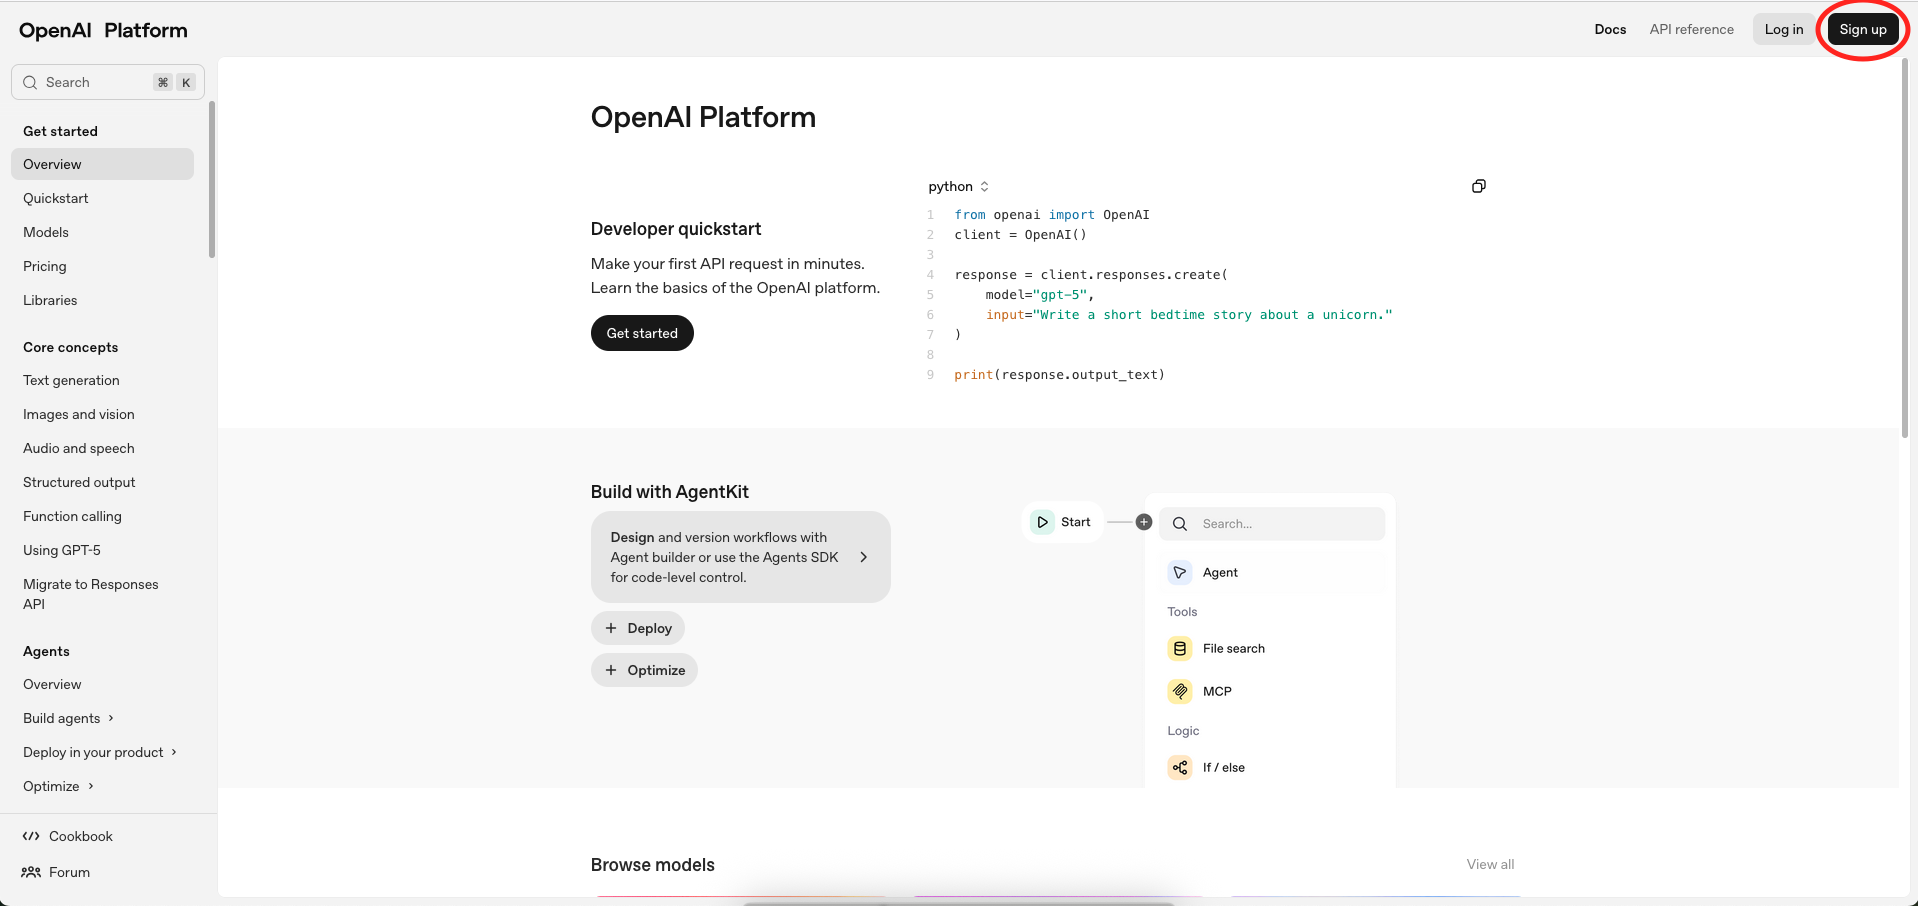

2. Click "Get Started"

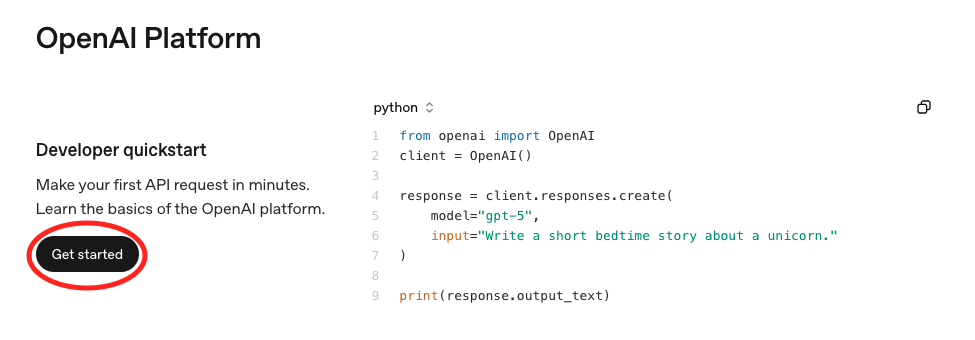

3. Follow the instructions. Name you organization and project whatever you like.

4. Add funds to your key. \\$5 should be plenty for participation in section. For reference, the models we will be using cost \\$0.25 per million tokens (words).

5. If you have any questions or issues, ask your peers for help.



## 0) Setup

Just run the code in the following block. If you are interested in how it works, feel free to poke inside.


In [ ]:
# @title
#@ Title
import os
import time
from typing import List, Dict

import openai
from openai import OpenAI

# Global conversation history (list of dicts with 'role' and 'content')
conversation_history: List[Dict[str, str]] = []



## 1) Add your API key and set a system prompt
- If you already set `OPENAI_API_KEY` in the environment, this will pick it up.
- Otherwise you'll be prompted *once* (input is hidden).  

In [ ]:
# @title

# ===============================
# API Key
# ===============================

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "")

if not OPENAI_API_KEY:
    try:
        import getpass
        OPENAI_API_KEY = getpass.getpass("Enter your OpenAI API key (input hidden): ").strip()
    except Exception:
        raise ValueError("Unable to capture API key input. Set os.environ['OPENAI_API_KEY'] manually.")

if not OPENAI_API_KEY:
    raise ValueError("Missing API key. Please provide a valid OpenAI API key.")

# Make the key available to the SDK
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY




## 2) Configuration & global state
- Pick a model (you can change later).  
- Turn token streaming on/off.  
- A simple `conversation_history` stores the last messages.


In [ ]:

# ===============================
# Configuration
# ===============================

MODEL = "gpt-5-mini"   # You can swap to "gpt-4o" or "gpt-4o-mini" if available

SYSTEM_PROMPT = "You are a helpful assistant" # Tweak this later, if you would like

# Instantiate a single client for the session
client = OpenAI(api_key=OPENAI_API_KEY)



## 3) ChatGPT Clone
**What this cell does**
- Builds a message list from the system prompt + recent history + your new user input.  
- Sends a request to the Chat Completions API.  
- Appends both user/assistant turns to `conversation_history`.

> Covering this code in depth is beyond the scope of this session. However, if you're curious about what it is doing, you can always ask Gemini (click the 3 dots on the top right of the block and select `Explain Code`

In [ ]:
# @title

def reset_history() -> None:
    """Clear the global conversation history."""
    conversation_history.clear()

def make_query(
    user_input: str,
    system_prompt: str = SYSTEM_PROMPT,
    model: str = MODEL,
    stream: bool = False,
    max_history: int = 10,
    retries: int = 2,
    backoff_seconds: float = 2.0,
) -> str:
    """Send a query with context and return the assistant's text."""
    global conversation_history

    # Build messages (system + recent context + current user)
    context = conversation_history[-max_history:]
    messages = [{"role": "system", "content": system_prompt}] + context

    if not context or context[-1].get("role") != "user" or context[-1].get("content") != user_input:
        messages.append({"role": "user", "content": user_input})

    attempt = 0
    while True:
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=messages,
                stream=stream,
            )

            full_text = ""

            if stream:
                print("\nAssistant:", end=" ", flush=True)
                for chunk in resp:
                    if chunk.choices:
                        delta = chunk.choices[0].delta
                        if delta and getattr(delta, "content", None):
                            token = delta.content
                            print(token, end="", flush=True)
                            full_text += token
                print()  # newline after stream
            else:
                full_text = resp.choices[0].message.content
                print("\nAssistant:", full_text)

            # Update history
            conversation_history.append({"role": "user", "content": user_input})
            conversation_history.append({"role": "assistant", "content": full_text})
            return full_text

        except openai.RateLimitError as e:
            if attempt >= retries:
                print(f"\nRate limit error after {attempt+1} attempt(s): {e}")
                return ""
            delay = backoff_seconds * (2 ** attempt)
            print(f"\nRate limit. Retrying in {delay:.1f}s...")
            time.sleep(delay)
            attempt += 1
        except (openai.APIError, openai.APIConnectionError, openai.BadRequestError) as e:
            print(f"\nAPI error: {e}")
            return ""
        except Exception as e:
            print(f"\nUnexpected error: {e}")
            return ""

def chat_once(prompt: str, **kwargs) -> str:
    """Convenience wrapper to send a single prompt and return text."""
    return make_query(prompt, **kwargs)




### Talk to ChatGPT like usual
Run the code block below. Type messages; type `exit` or `quit` (or interrupt the cell) to stop.

#### After having a conversation with ChatGPT, feel free to change the `SYSTEM_PROMPT` field. As discussed, this will change the tone or role of the assistant. See what you can get it to do!


```
# This is formatted as code
```


> This is only the beginning of where things start to break from ChatGPT.



In [ ]:
# @title
SYSTEM_PROMPT = "You are a helpful assistant" # Tweak this later, if you would like

reset_history()
print("Chat started. Type 'exit' to stop.\n")
while True:
    try:
        user_in = input("You: ").strip()
    except EOFError:
        break
    if user_in.lower() in {"exit", "quit"}:
        print("Goodbye!")
        break
    _ = make_query(user_in)


# Part 1: Your First API Request

This is what most API requests to OpenAI will look like. Fill in the "[YOUR PROMPT HERE]" space however you'd like, then run the cell.

In [ ]:
SYSTEM_PROMPT = "You are a helpful assistant" # Change this to elicit different behavior

resp = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": "[YOUR PROMPT HERE]"}, # Ask ChatGPT whatever you want here!
    ],
)
print(resp.choices[0].message.content)



# Part 2 · Vibe‑Coding Challenge

**Goal:** Use generative AI as your *primary coder/author* to rapidly prototype ideas around a policy topic. I would reccomend using ChatGPT in a separate tab, though you also have Gemini access directly in this notebook (though I have found it to be buggy)

**What to try**
- Start simple (haiku/poem) and then move to summaries, debates, or an interactive issue chat.
- Modify prompts. Combine outputs. Iterate quickly.
- There’s no single correct approach; we’ll share takeaways at the end.

**Timebox:** Work until ~5–10 minutes before the end; be ready to share.



## Option 1: Policy‑themed haiku or poem (easy)
Change the topic to something you care about.


In [ ]:
SYSTEM_PROMPT = "You are a world famous poet."

resp = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": "[YOUR HAIKU HERE]"}, # Ask ChatGPT whatever you want here!
    ],
)

print(resp.choices[0].message.content)



## Option 2: Policy summary bot (medium)
Paste a short excerpt (or a brief description) below of an article or policy memo of interest to you. If the text is long, summarize the relevant parts first.


In [ ]:

policy_text = """
[Paste or briefly describe a policy, report, or issue here. If long, summarize key excerpts.]
"""

prompt = f"""
You are a policy analysis bot.
1) Read the policy content below.
2) Provide a concise summary (bulleted).
3) Suggest a creative, actionable recommendation (2-3 bullets).
4) Flag key tradeoffs and uncertainties.

POLICY CONTENT:
{policy_text}
"""

# Your turn! Implement an API request that sends both the policy text and the prompt to the model.



## Option 3: “issue of interest” query (medium)
Prompt the user to input a policy area of interest, and send a request to the model asking for for a discussion of that area.

In [ ]:
SYSTEM_PROMPT = "" # Design the tone you want your bot to have when responding to the user's request

# To capture interactive user input, you can use the input() function
# For example: input("What is your policy area of interest? ")
# You should pass the user input policy area of interest, your system prompt, and any other prompt scaffolding you see fit.



## 11) Debate simulator (easy → hard)
Start small with a pro/con. Then try two distinct 'agents' and a neutral moderator.


In [ ]:

# Simple version

# Ask an LLM to weigh the pros and cons of a specific policy area of interest.

### Two Agent Extension

Make two separate requests for each of these agents (these are system prompts). Change the system prompts as you see fit.

#### Extensions:

1. Have Agent B not only present their case but respond to Agent A. How might you do that?
2. Have the agents iteratively discuss things (use a `for` loop and feed the messages back and forth
3. Implement a debate moderator who looks at both messages and summarizes them.

How does having two different LLMs with two different system prompts change the quality of discussion?

In [ ]:

# Two-agent extension

agent_a = "You are a policy analyst focused on efficiency and growth."
agent_b = "You are a policy analyst focused on equity and distribution."

# Make two separate requests for each of these agents.

# Extensions:



# Reflection

Make note of any trouble you ran into while coding any of these tasks. What worked? What didnt work?